<a href="https://colab.research.google.com/github/TaillessTanuki/Berita_Banggai/blob/main/Berita_Banggai_MK_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [2]:
!pip install Sastrawi
!pip install clean-text
!pip install deep-translator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 7.5 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171034 sha256=a29f4c5f8a0e3859962d3bb090d207ca184457d3e9185ca1f0fa3055b42eb2fe
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from cleantext import clean
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
import sklearn

In [5]:
# !pip freeze > requirements.txt

# Get Data from ES and prepare DF

In [6]:
import requests
import json

In [7]:
elasticsearch_url = 'https://es-1.datanusantara.com:9201'
username = 'adminkibana'
password = 'kibanaPASS!@#2019'
index_endpoint = 'news-crawl-production-v2'

In [14]:
#query = {
#    "_source": ["text", "source","source_detail","target"],
 #   "size":600,
  #  "query": {
   #     "match": {
    #              "source": "news"
     #           },
      #  "match": {
       #     "target": "banggai"
  #      }
 #   }
#}

#search_url = f"{elasticsearch_url}/{index_endpoint}/_search"
#response = requests.get(search_url, json=query, auth=(username, password))

In [8]:
query = {
  "_source": ["target", "title","description_content"],
  "size": 1000,
  "query": {
    "bool": {
      "must": [],
      "filter": [
        {
          "match_all": {}
        },
        {
          "bool": {
            "should": [


              {
                "match_phrase": {
                  "target": "banggai"
                }
              }
            ],
            "minimum_should_match": 1


          }
        }
      ]
    }
  }
}
search_url = f"{elasticsearch_url}/{index_endpoint}/_search"
response = requests.get(search_url, json=query, auth=(username, password))

In [9]:
search_url


'https://es-1.datanusantara.com:9201/news-crawl-production-v2/_search'

In [10]:
search_results = response.json()
# print(json.dumps(search_results, indent=2))
print(len(search_results['hits']['hits']))

1000


In [11]:
# Parse the response to extract relevant data
search_results = response.json()

# Process the data and create a DataFrame
data = []
for hit in search_results.get("hits", {}).get("hits", []):
    target = hit["_source"]["target"]
    title = hit["_source"]["title"]
    text = hit["_source"]["description_content"]

    data.append({"target": target,  "title": title, "text": text})

# Create a DataFrame
df = pd.DataFrame(data)
print(df.head())

    target                                              title  \
0  banggai  Mobil Sim Keliling Polres Banggai Meriahkan Pa...   
1  banggai  Film Horor “Piara Mayat”,  Kreativitas Anak Mu...   
2  banggai  Festival Malabot Tumbe 2023 Kembali Meriahkan ...   
3  banggai  Rakor Kampanye Damai Pemilu 2024, Polres Bangg...   
4  banggai  Bawaslu Banggai Perkuat Koordinasi dengan Panw...   

                                                text  
0  KABAR LUWUK –  Suasana Pasar Murah bersubsidi ...  
1  KABAR LUWUK  –  Film Horor“Piara Mayat”,Kreati...  
2  KABAR LUWUK  –Festival Malabot Tumbe 2023Kemba...  
3  “Kerja Cepat dan Terkoordinir dalam Penerbitan...  
4  KABAR LUWUK  –Bawaslu BanggaiPerkuat Koordinas...  


In [24]:
# For manual Review
#import random

# Set the number of random samples you want to select
#num_samples = 100  # Adjust this number as needed

# Select random samples from the DataFrame
#random_indices = random.sample(range(len(df)), num_samples)
#random_data = df.iloc[random_indices][["title", "text"]]

# Save random data to a CSV file
#random_data.to_csv("random_data.csv")


In [ ]:
df

In [ ]:
df.info()

# Preprocessing

## Delete Duplicates

In [12]:
df.duplicated(subset='title').sum()

25

In [13]:
df = df.drop_duplicates(subset='title')

## Case Folding

In [14]:
def clean_lower(lwr):
    lwr = lwr.lower() # lowercase text
    return lwr

In [15]:
# Buat kolom tambahan untuk data ulasan yang telah dicasefolding
df['lwr'] = df['text'].apply(clean_lower)
df['lwr']

0      kabar luwuk –  suasana pasar murah bersubsidi ...
1      kabar luwuk  –  film horor“piara mayat”,kreati...
2      kabar luwuk  –festival malabot tumbe 2023kemba...
3      “kerja cepat dan terkoordinir dalam penerbitan...
4      kabar luwuk  –bawaslu banggaiperkuat koordinas...
                             ...                        
995    terasbanggai.com -bawaslu banggai akan meningk...
996    banggai raya-bupati banggai, ir. h. amirudin m...
997    terasbanggai.com- setelah sempat tertunda masa...
998    banggai, 25 januari 2024 – bertempat di ruang ...
999    banggai raya-bawaslu kabupaten banggai menggel...
Name: lwr, Length: 975, dtype: object

In [30]:
df.head()

,target,title,text,lwr
0,banggai,Mobil Sim Keliling Polres Banggai Meriahkan Pa...,KABAR LUWUK – Suasana Pasar Murah bersubsidi ...,kabar luwuk – suasana pasar murah bersubsidi ...
1,banggai,"Film Horor “Piara Mayat”, Kreativitas Anak Mu...","KABAR LUWUK – Film Horor“Piara Mayat”,Kreati...","kabar luwuk – film horor“piara mayat”,kreati..."
2,banggai,Festival Malabot Tumbe 2023 Kembali Meriahkan ...,KABAR LUWUK –Festival Malabot Tumbe 2023Kemba...,kabar luwuk –festival malabot tumbe 2023kemba...
3,banggai,"Rakor Kampanye Damai Pemilu 2024, Polres Bangg...",“Kerja Cepat dan Terkoordinir dalam Penerbitan...,“kerja cepat dan terkoordinir dalam penerbitan...
4,banggai,Bawaslu Banggai Perkuat Koordinasi dengan Panw...,KABAR LUWUK –Bawaslu BanggaiPerkuat Koordinas...,kabar luwuk –bawaslu banggaiperkuat koordinas...


In [31]:
print(df['text'][30])
print("_______________________________________________________________________________________________________________")
print(df['lwr'][30])

KABAR LUWUK  –Dinas Sosial BanggaiSegera Salurkan 2.42 MiliarProgram Gercep Gaskan Berdaya2023.Dinas Sosial Kabupaten Banggaimenerima bantuan sebesar 2.42 miliar rupiah dalam program Gerak Cepat Pengentasan Kemiskinan Berbasis Pemberdayaan Masyarakat (GERCEP GASKAN BERDAYA).Bantuan ini ditujukan untuk 242 keluarga penerima manfaat di lima kecamatan, memberikan harapan bagi warga di Kecamatan Luwuk (35 KPM), Luwuk Selatan (28 KPM), Pagimana (95 KPM), Bunta (47 KPM), dan Nuhon (37 KPM). Selasa 28/11/2023.Kepala Dinas Sosial Kabupaten Banggai, Irpan Poma melalui Kepala Bidang Fakir Miskis,Ronald Putje,menyampaikan kepada media bahwa dana bantuan ini merupakan sumbangan langsung dari Pemerintah Provinsi Sulawesi Tengah.Dinas Sosial Kabupaten Banggai bertanggung jawab dalam memfasilitasi distribusi bantuan dan ikut serta dalam pengawasan ketat agar dana tersebut benar-benar sampai kepada penerima manfaat yang tepat.Data yang tersedia menunjukkan bahwa 242 Keluarga Penerima Manfaat yang terd

## Cleansing

### Remove Numbers

In [16]:
def remove_numbers(text):
  text = re.sub('[0-9]+', '', text)
  return text

In [17]:
df['clean_number'] = df['lwr'].apply(remove_numbers)
df['clean_number']

0      kabar luwuk –  suasana pasar murah bersubsidi ...
1      kabar luwuk  –  film horor“piara mayat”,kreati...
2      kabar luwuk  –festival malabot tumbe kembali m...
3      “kerja cepat dan terkoordinir dalam penerbitan...
4      kabar luwuk  –bawaslu banggaiperkuat koordinas...
                             ...                        
995    terasbanggai.com -bawaslu banggai akan meningk...
996    banggai raya-bupati banggai, ir. h. amirudin m...
997    terasbanggai.com- setelah sempat tertunda masa...
998    banggai,  januari  – bertempat di ruang sidang...
999    banggai raya-bawaslu kabupaten banggai menggel...
Name: clean_number, Length: 975, dtype: object

In [35]:
df.tail()

,target,title,text,lwr,clean_number
995,banggai,Jelang Voting Day Bawaslu Banggai Gelar Apel S...,Terasbanggai.com -Bawaslu Banggai akan meningk...,terasbanggai.com -bawaslu banggai akan meningk...,terasbanggai.com -bawaslu banggai akan meningk...
996,banggai,Bupati Banggai Ajak Warga Download Mobile JKN ...,"BANGGAI RAYA-Bupati Banggai, Ir. H. Amirudin M...","banggai raya-bupati banggai, ir. h. amirudin m...","banggai raya-bupati banggai, ir. h. amirudin m..."
997,banggai,"Banggai Bakal Gunakan Listrik Tenaga Gas, Hari...",Terasbanggai.com- Setelah sempat tertunda masa...,terasbanggai.com- setelah sempat tertunda masa...,terasbanggai.com- setelah sempat tertunda masa...
998,banggai,Asistensi Pengisian SPT Tahunan dan Pemadanan ...,"Banggai, 25 Januari 2024 – Bertempat di ruang ...","banggai, 25 januari 2024 – bertempat di ruang ...","banggai, januari – bertempat di ruang sidang..."
999,banggai,Bawaslu Banggai Gelar Sosialisasi Pencegahan B...,BANGGAI RAYA-Bawaslu Kabupaten Banggai menggel...,banggai raya-bawaslu kabupaten banggai menggel...,banggai raya-bawaslu kabupaten banggai menggel...


### Remove Punctuation

In [18]:
#Remove Puncutuation
clean_spcl = re.compile('[/(){}\[\]\|@,;]')
clean_symbol = re.compile('[^0-9a-z]')
def clean_punct(text):
    text = clean_spcl.sub('', text)
    text = clean_symbol.sub(' ', text)
    return text

In [19]:
# Buat kolom tambahan untuk data description yang telah diremovepunctuation
df['clean_punct'] = df['clean_number'].apply(clean_punct)
df['clean_punct']

0      kabar luwuk    suasana pasar murah bersubsidi ...
1      kabar luwuk     film horor piara mayat kreativ...
2      kabar luwuk   festival malabot tumbe kembali m...
3       kerja cepat dan terkoordinir dalam penerbitan...
4      kabar luwuk   bawaslu banggaiperkuat koordinas...
                             ...                        
995    terasbanggai com  bawaslu banggai akan meningk...
996    banggai raya bupati banggai ir  h  amirudin mm...
997    terasbanggai com  setelah sempat tertunda masa...
998    banggai  januari    bertempat di ruang sidang ...
999    banggai raya bawaslu kabupaten banggai menggel...
Name: clean_punct, Length: 975, dtype: object

In [38]:
df.head()


,target,title,text,lwr,clean_number,clean_punct
0,banggai,Mobil Sim Keliling Polres Banggai Meriahkan Pa...,KABAR LUWUK – Suasana Pasar Murah bersubsidi ...,kabar luwuk – suasana pasar murah bersubsidi ...,kabar luwuk – suasana pasar murah bersubsidi ...,kabar luwuk suasana pasar murah bersubsidi ...
1,banggai,"Film Horor “Piara Mayat”, Kreativitas Anak Mu...","KABAR LUWUK – Film Horor“Piara Mayat”,Kreati...","kabar luwuk – film horor“piara mayat”,kreati...","kabar luwuk – film horor“piara mayat”,kreati...",kabar luwuk film horor piara mayat kreativ...
2,banggai,Festival Malabot Tumbe 2023 Kembali Meriahkan ...,KABAR LUWUK –Festival Malabot Tumbe 2023Kemba...,kabar luwuk –festival malabot tumbe 2023kemba...,kabar luwuk –festival malabot tumbe kembali m...,kabar luwuk festival malabot tumbe kembali m...
3,banggai,"Rakor Kampanye Damai Pemilu 2024, Polres Bangg...",“Kerja Cepat dan Terkoordinir dalam Penerbitan...,“kerja cepat dan terkoordinir dalam penerbitan...,“kerja cepat dan terkoordinir dalam penerbitan...,kerja cepat dan terkoordinir dalam penerbitan...
4,banggai,Bawaslu Banggai Perkuat Koordinasi dengan Panw...,KABAR LUWUK –Bawaslu BanggaiPerkuat Koordinas...,kabar luwuk –bawaslu banggaiperkuat koordinas...,kabar luwuk –bawaslu banggaiperkuat koordinas...,kabar luwuk bawaslu banggaiperkuat koordinas...


### Delete whitespaces

In [39]:
def normalize_whitespace(text):
    corrected = str(text)
    corrected = re.sub(r"//t",r"\t", corrected)
    corrected = re.sub(r"( )\1+",r"\1", corrected)
    corrected = re.sub(r"(\n)\1+",r"\1", corrected)
    corrected = re.sub(r"(\r)\1+",r"\1", corrected)
    corrected = re.sub(r"(\t)\1+",r"\1", corrected)
    return corrected.strip(" ")

In [40]:
df['clean_double_ws'] = df['clean_punct'].apply(normalize_whitespace)
df['clean_double_ws']

<ipython-input-40-364f8f51d79a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_double_ws'] = df['clean_punct'].apply(normalize_whitespace)


0      kabar luwuk suasana pasar murah bersubsidi di ...
1      kabar luwuk film horor piara mayat kreativitas...
2      kabar luwuk festival malabot tumbe kembali mer...
3      kerja cepat dan terkoordinir dalam penerbitan ...
4      kabar luwuk bawaslu banggaiperkuat koordinasi ...
                             ...                        
995    terasbanggai com bawaslu banggai akan meningka...
996    banggai raya bupati banggai ir h amirudin mm a...
997    terasbanggai com setelah sempat tertunda masa ...
998    banggai januari bertempat di ruang sidang pada...
999    banggai raya bawaslu kabupaten banggai menggel...
Name: clean_double_ws, Length: 975, dtype: object

In [41]:
df.tail()

,target,title,text,lwr,clean_number,clean_punct,clean_double_ws
995,banggai,Jelang Voting Day Bawaslu Banggai Gelar Apel S...,Terasbanggai.com -Bawaslu Banggai akan meningk...,terasbanggai.com -bawaslu banggai akan meningk...,terasbanggai.com -bawaslu banggai akan meningk...,terasbanggai com bawaslu banggai akan meningk...,terasbanggai com bawaslu banggai akan meningka...
996,banggai,Bupati Banggai Ajak Warga Download Mobile JKN ...,"BANGGAI RAYA-Bupati Banggai, Ir. H. Amirudin M...","banggai raya-bupati banggai, ir. h. amirudin m...","banggai raya-bupati banggai, ir. h. amirudin m...",banggai raya bupati banggai ir h amirudin mm...,banggai raya bupati banggai ir h amirudin mm a...
997,banggai,"Banggai Bakal Gunakan Listrik Tenaga Gas, Hari...",Terasbanggai.com- Setelah sempat tertunda masa...,terasbanggai.com- setelah sempat tertunda masa...,terasbanggai.com- setelah sempat tertunda masa...,terasbanggai com setelah sempat tertunda masa...,terasbanggai com setelah sempat tertunda masa ...
998,banggai,Asistensi Pengisian SPT Tahunan dan Pemadanan ...,"Banggai, 25 Januari 2024 – Bertempat di ruang ...","banggai, 25 januari 2024 – bertempat di ruang ...","banggai, januari – bertempat di ruang sidang...",banggai januari bertempat di ruang sidang ...,banggai januari bertempat di ruang sidang pada...
999,banggai,Bawaslu Banggai Gelar Sosialisasi Pencegahan B...,BANGGAI RAYA-Bawaslu Kabupaten Banggai menggel...,banggai raya-bawaslu kabupaten banggai menggel...,banggai raya-bawaslu kabupaten banggai menggel...,banggai raya bawaslu kabupaten banggai menggel...,banggai raya bawaslu kabupaten banggai menggel...


## Stemming

In [42]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
stem_factory = StemmerFactory()
stemmer = stem_factory.create_stemmer()

In [ ]:
#factory = StemmerFactory()
#stemmer = factory.create_stemmer()

In [43]:
def stem(text):
  return stemmer.stem(text)

In [44]:
df['stemmed'] = df['clean_double_ws'].apply(stem)
df['stemmed']

<ipython-input-44-27d9ad4a5fe7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stemmed'] = df['clean_double_ws'].apply(stem)


0      kabar luwuk suasana pasar murah subsidi di kab...
1      kabar luwuk film horor piara mayat kreativitas...
2      kabar luwuk festival malabot tumbe kembali mer...
3      kerja cepat dan terkoordinir dalam terbit sttp...
4      kabar luwuk bawaslu banggaiperkuat koordinasi ...
                             ...                        
995    terasbanggai com bawaslu bangga akan tingkat a...
996    bangga raya bupati bangga ir h amirudin mm aif...
997    terasbanggai com telah sempat tunda masa uji c...
998    bangga januari tempat di ruang sidang pada har...
999    bangga raya bawaslu kabupaten bangga gelar sos...
Name: stemmed, Length: 975, dtype: object

In [45]:
df.head()

,target,title,text,lwr,clean_number,clean_punct,clean_double_ws,stemmed
0,banggai,Mobil Sim Keliling Polres Banggai Meriahkan Pa...,KABAR LUWUK – Suasana Pasar Murah bersubsidi ...,kabar luwuk – suasana pasar murah bersubsidi ...,kabar luwuk – suasana pasar murah bersubsidi ...,kabar luwuk suasana pasar murah bersubsidi ...,kabar luwuk suasana pasar murah bersubsidi di ...,kabar luwuk suasana pasar murah subsidi di kab...
1,banggai,"Film Horor “Piara Mayat”, Kreativitas Anak Mu...","KABAR LUWUK – Film Horor“Piara Mayat”,Kreati...","kabar luwuk – film horor“piara mayat”,kreati...","kabar luwuk – film horor“piara mayat”,kreati...",kabar luwuk film horor piara mayat kreativ...,kabar luwuk film horor piara mayat kreativitas...,kabar luwuk film horor piara mayat kreativitas...
2,banggai,Festival Malabot Tumbe 2023 Kembali Meriahkan ...,KABAR LUWUK –Festival Malabot Tumbe 2023Kemba...,kabar luwuk –festival malabot tumbe 2023kemba...,kabar luwuk –festival malabot tumbe kembali m...,kabar luwuk festival malabot tumbe kembali m...,kabar luwuk festival malabot tumbe kembali mer...,kabar luwuk festival malabot tumbe kembali mer...
3,banggai,"Rakor Kampanye Damai Pemilu 2024, Polres Bangg...",“Kerja Cepat dan Terkoordinir dalam Penerbitan...,“kerja cepat dan terkoordinir dalam penerbitan...,“kerja cepat dan terkoordinir dalam penerbitan...,kerja cepat dan terkoordinir dalam penerbitan...,kerja cepat dan terkoordinir dalam penerbitan ...,kerja cepat dan terkoordinir dalam terbit sttp...
4,banggai,Bawaslu Banggai Perkuat Koordinasi dengan Panw...,KABAR LUWUK –Bawaslu BanggaiPerkuat Koordinas...,kabar luwuk –bawaslu banggaiperkuat koordinas...,kabar luwuk –bawaslu banggaiperkuat koordinas...,kabar luwuk bawaslu banggaiperkuat koordinas...,kabar luwuk bawaslu banggaiperkuat koordinasi ...,kabar luwuk bawaslu banggaiperkuat koordinasi ...


In [46]:
df['stemmed'].to_csv("stemmed_words_tanpa_token_stopwordk.csv", index=False)

In [ ]:
print(df['filtered'][0])
print(df['stemmed'][0])

kabar suasana pasar murah bersubsidi banggai lebih semarak kehadiran satuan lalulintas polres banggai membawa mobil sim keliling senin keberadaan sekadar pelayanan juga menandai sinergi polres banggai kejaksaan negeri banggai terjalin kuat kepala satuan lintas polres banggai akp i made bagus adityamelalui kanit regiden ipda suparjan memimpin stand pameran sim keliling pasar murah bersubsidi suparjan kegiatan merupakan upaya konkret mendekatkan kepada masyarakat pengurusan perpanjangan surat izin mengemudi sim masyarakat banggai mudah mengurus perpanjangan sim harus repot ke kantor satpas polres banggai dihalimun dengan mobil sim keliling telah disediakan tim pelayanan dilayani suasana ramai ipda suparjan menekankan bahwa kehadiran mobil sim keliling bentuk inovatif memudahkan akses masyarakat dalam administrasi sim tim dalam mobil siap memberikan pelayanan terbaik memastikan proses perpanjangan sim berjalan lancar efisien ini hanya memudahkan juga memperkuat ikatan institusi kepolisian

In [47]:
print(len(df['clean_double_ws'][0]))
print(len(df['stemmed'][0]))

1659
1420


## Stopword Removal

### Get custom stopwords

In [48]:
url = 'https://raw.githubusercontent.com/TaillessTanuki/ID-Stopwords/main/ID-Stopwords(MasDevid,Modified).csv'
df_stopword = pd.read_csv(url, delimiter = ";",encoding='cp1252')

In [49]:
df_stopword.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765 entries, 0 to 764
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Stopwords  765 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


In [51]:
df_stopword

,Stopwords
0,ada
1,adalah
2,adanya
3,adapun
4,agak
...,...
760,kabupaten
761,ini
762,itu
763,luwuk


In [52]:
custom_stopword = list(df_stopword['Stopwords'])
custom_stopword

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara',
 'antaranya',
 'apa',
 'apaan',
 'apabila',
 'apakah',
 'apalagi',
 'apatah',
 'artinya',
 'asal',
 'asalkan',
 'atas',
 'atau',
 'ataukah',
 'ataupun',
 'awal',
 'awalnya',
 'bagai',
 'bagaikan',
 'bagaimana',
 'bagaimanakah',
 'bagaimanapun',
 'bagi',
 'bagian',
 'bahkan',
 'bahwa',
 'bahwasanya',
 'baik',
 'bakal',
 'bakalan',
 'balik',
 'banyak',
 'bapak',
 'baru',
 'bawah',
 'beberapa',
 'begini',
 'beginian',
 'beginikah',
 'beginilah',
 'begitu',
 'begitukah',
 'begitulah',
 'begitupun',
 'bekerja',
 'belakang',
 'belakangan',
 'belum',
 'belumlah',
 'benar',
 'benarkah',
 'benarlah',
 'berada',
 'berakhir',
 'berakhirlah',
 'berakhirnya',
 'berapa',
 'berapakah',
 'berapalah',
 'berapapun',
 'berarti',
 'berawal',
 'berbagai',
 'berdatangan',
 'beri',
 'berikan',
 'berikut'

### Removal

In [ ]:
# Prepare stopword remover
factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words() + custom_stopword
print(stopwords)

['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'sementara', 'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'pula', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sampai', 'sedangkan', 'selagi', 'sementara', 'tetapi', 'apakah', 'kecuali', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'tapi', 'ingin', 'juga', 'nggak', 'mari', 'nanti', 'melainkan', '

In [53]:
# using only sastrawy
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()

In [54]:
len(stopwords)

126

In [55]:
dictionary = ArrayDictionary(stopwords)
stopword = StopWordRemover(dictionary)

In [56]:
def filtering(text):
  stop = stopword.remove(text)
  return stop

In [ ]:
df

In [57]:
df['filtered'] = df['clean_double_ws'].apply(filtering)
df['filtered']

<ipython-input-57-84c28c275823>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['filtered'] = df['clean_double_ws'].apply(filtering)


0      kabar luwuk suasana pasar murah bersubsidi kab...
1      kabar luwuk film horor piara mayat kreativitas...
2      kabar luwuk festival malabot tumbe meriahkanka...
3      kerja cepat terkoordinir penerbitan sttp kabar...
4      kabar luwuk bawaslu banggaiperkuat koordinasi ...
                             ...                        
995    terasbanggai com bawaslu banggai meningkatkan ...
996    banggai raya bupati banggai ir h amirudin mm a...
997    terasbanggai com sempat tertunda masa uji coba...
998    banggai januari bertempat ruang sidang hari ka...
999    banggai raya bawaslu kabupaten banggai menggel...
Name: filtered, Length: 975, dtype: object

In [58]:
df.head()

,target,title,text,lwr,clean_number,clean_punct,clean_double_ws,stemmed,filtered
0,banggai,Mobil Sim Keliling Polres Banggai Meriahkan Pa...,KABAR LUWUK – Suasana Pasar Murah bersubsidi ...,kabar luwuk – suasana pasar murah bersubsidi ...,kabar luwuk – suasana pasar murah bersubsidi ...,kabar luwuk suasana pasar murah bersubsidi ...,kabar luwuk suasana pasar murah bersubsidi di ...,kabar luwuk suasana pasar murah subsidi di kab...,kabar luwuk suasana pasar murah bersubsidi kab...
1,banggai,"Film Horor “Piara Mayat”, Kreativitas Anak Mu...","KABAR LUWUK – Film Horor“Piara Mayat”,Kreati...","kabar luwuk – film horor“piara mayat”,kreati...","kabar luwuk – film horor“piara mayat”,kreati...",kabar luwuk film horor piara mayat kreativ...,kabar luwuk film horor piara mayat kreativitas...,kabar luwuk film horor piara mayat kreativitas...,kabar luwuk film horor piara mayat kreativitas...
2,banggai,Festival Malabot Tumbe 2023 Kembali Meriahkan ...,KABAR LUWUK –Festival Malabot Tumbe 2023Kemba...,kabar luwuk –festival malabot tumbe 2023kemba...,kabar luwuk –festival malabot tumbe kembali m...,kabar luwuk festival malabot tumbe kembali m...,kabar luwuk festival malabot tumbe kembali mer...,kabar luwuk festival malabot tumbe kembali mer...,kabar luwuk festival malabot tumbe meriahkanka...
3,banggai,"Rakor Kampanye Damai Pemilu 2024, Polres Bangg...",“Kerja Cepat dan Terkoordinir dalam Penerbitan...,“kerja cepat dan terkoordinir dalam penerbitan...,“kerja cepat dan terkoordinir dalam penerbitan...,kerja cepat dan terkoordinir dalam penerbitan...,kerja cepat dan terkoordinir dalam penerbitan ...,kerja cepat dan terkoordinir dalam terbit sttp...,kerja cepat terkoordinir penerbitan sttp kabar...
4,banggai,Bawaslu Banggai Perkuat Koordinasi dengan Panw...,KABAR LUWUK –Bawaslu BanggaiPerkuat Koordinas...,kabar luwuk –bawaslu banggaiperkuat koordinas...,kabar luwuk –bawaslu banggaiperkuat koordinas...,kabar luwuk bawaslu banggaiperkuat koordinas...,kabar luwuk bawaslu banggaiperkuat koordinasi ...,kabar luwuk bawaslu banggaiperkuat koordinasi ...,kabar luwuk bawaslu banggaiperkuat koordinasi ...


In [ ]:
len(df)

975

In [59]:
print(df['clean_double_ws'][69])
print(df['filtered'][69])

kabar luwuk ratusan buruh kepung dinas koperasidan kupp luwuk hingga akhirnya mencapai kesepakatan menjadi saksi dari aksi protes massal yang melibatkan ratusan buruhtangkiang mahasiswa dan masyarakat yang berkumpul untuk mendesak pembatalan pernyataan kontroversial plh kepala kupp kelas ii luwuk nukman larau rabu november kontroversi dimulai setelah rapat forkopimda banggai pada senin november di mana nukman larau mengakomodir kepengurusan baruuupj tangkiang yang dikeluarkan oleh koperasi tkbm teluk lalong perubahan kepengurusan ini mencakup penggantian ketua dan beberapa pengurus dengan orang yang bukan anggota uupj tangkiang protes muncul ketika sk pergantian kepengurusan ditolak oleh seluruh anggota uupj tangkiang dalam rapat luar biasa mereka tetap memilih amir mangulele sebagai ketua menyatakan penolakan terhadap upaya mengadu domba buruh yang dianggap dilakukan oleh koperasi tkbm teluk lalong selanjutnya massa aksi memulai pengepungan kantor dinas koperasi menuntut agar nukman l

##Second Stopwords

In [ ]:
df['filtered2'] = df['stemmed'].apply(stem)
df['filtered2']

0      kabar suasana pasar murah subsidi bangga lebih...
1      kabar film horor piara mayat kreativitasanak m...
2      kabar festival malabot tumbe meriahkankabupate...
3      kerja cepat terkoordinir terbit sttp kabar rak...
4      kabar bawaslu banggaiperkuat koordinasi dengan...
                             ...                        
995    terasbanggai com bawaslu bangga tingkat awas j...
996    bangga raya bupati bangga ir h amirudin mm aif...
997    terasbanggai com sempat tunda uji coba kontrak...
998    bangga januari tempat ruang sidang hari kamis ...
999    bangga raya bawaslu bangga gelar sosialisasi i...
Name: filtered2, Length: 975, dtype: object

In [ ]:
df.drop(columns=['tokenized'], inplace=True)

In [ ]:
df.head()

In [ ]:
print(df['stemmed'][0])
print(df['filtered2'][0])

kabar suasana pasar murah subsidi bangga lebih semarak hadir satu lalulintas polres bangga bawa mobil sim keliling senin ada sekadar layan juga tanda sinergi polres bangga jaksa negeri bangga jalin kuat kepala satu lintas polres bangga akp i made bagus adityamelalui kanit regiden ipda suparjan pimpin stand pamer sim keliling pasar murah subsidi suparjan giat rupa upaya konkret dekat kepada masyarakat urus panjang surat izin kemudi sim masyarakat bangga mudah urus panjang sim harus repot ke kantor satpas polres bangga halimun dengan mobil sim keliling telah sedia tim layan layan suasana ramai ipda suparjan tekan bahwa hadir mobil sim keliling bentuk inovatif mudah akses masyarakat dalam administrasi sim tim dalam mobil siap beri layan baik pasti proses panjang sim jalan lancar efisien ini hanya mudah juga kuat ikat institusi polisi jaksa dengan masyarakat pasar murah subsidi selenggara jaksa negeri bangga bukan hanya ajang ekonomi juga platform dekat dengan masyarakat ada mobil sim keli

## Tokenizing

In [60]:
def tokenize(text):
  tokens = nltk.tokenize.word_tokenize(text)
  return tokens

In [61]:
df['tokenized'] = df['filtered'].apply(tokenize)
df['tokenized']

<ipython-input-61-164acad3ea72>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized'] = df['filtered'].apply(tokenize)


0      [kabar, luwuk, suasana, pasar, murah, bersubsi...
1      [kabar, luwuk, film, horor, piara, mayat, krea...
2      [kabar, luwuk, festival, malabot, tumbe, meria...
3      [kerja, cepat, terkoordinir, penerbitan, sttp,...
4      [kabar, luwuk, bawaslu, banggaiperkuat, koordi...
                             ...                        
995    [terasbanggai, com, bawaslu, banggai, meningka...
996    [banggai, raya, bupati, banggai, ir, h, amirud...
997    [terasbanggai, com, sempat, tertunda, masa, uj...
998    [banggai, januari, bertempat, ruang, sidang, h...
999    [banggai, raya, bawaslu, kabupaten, banggai, m...
Name: tokenized, Length: 975, dtype: object

In [ ]:
df

In [62]:
print(df['filtered'][0])
print(df['tokenized'][0])

kabar luwuk suasana pasar murah bersubsidi kabupaten banggai menjadi lebih semarak kehadiran satuan lalulintas polres banggai membawa mobil sim keliling senin keberadaan bukan sekadar pelayanan juga menandai sinergi polres banggai kejaksaan negeri banggai terjalin kuat kepala satuan lalu lintas polres banggai akp i made bagus adityamelalui kanit regiden ipda suparjan memimpin stand pameran sim keliling pasar murah bersubsidi suparjan menjelaskan kegiatan merupakan upaya konkret mendekatkan diri masyarakat terutama pengurusan perpanjangan surat izin mengemudi sim masyarakat kabupaten banggai mudah mengurus perpanjangan sim harus repot datang kantor satpas polres banggai dihalimun cukup mendatangi mobil sim keliling telah disediakan tim pelayanan siap dilayani ujarnya suasana ramai ipda suparjan menekankan kehadiran mobil sim keliling bentuk inovatif memudahkan akses masyarakat administrasi sim tim mobil siap memberikan pelayanan terbaik memastikan proses perpanjangan sim berjalan lancar

In [ ]:
print(len(df['stemmed'][0]))
print(len(df['tokenized'][0]))

## Convert df to excel

In [ ]:
df.to_excel('lexicon_analytics_banggai_news.xlsx', index=False)

## Delete Most and Least Appeared Words. Convert it to DTM





In [64]:
# Convert tokenized text to string representation
text_strings = [' '.join(doc) for doc in df['tokenized']]


In [ ]:
text_strings

In [66]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#cv = CountVectorizer(max_df=0.9, min_df=2, stop_words= stopwords)

vect =TfidfVectorizer(max_df=0.9, min_df=2, stop_words= stopwords)

dtm = cv.fit_transform(text_strings)

In [67]:
dtm

<975x7830 sparse matrix of type '<class 'numpy.int64'>'
	with 110931 stored elements in Compressed Sparse Row format>

#Model LDA

In [68]:
from sklearn.decomposition import LatentDirichletAllocation

In [69]:
#Choosing how many topics that we want (n_component)
LDA = LatentDirichletAllocation(n_components=10,random_state=720)

#Fitting the data(dtm)
LDA.fit(dtm)

LatentDirichletAllocation(random_state=720)

##Grab the vocabulary words

In [ ]:

len(cv.get_feature_names_out())


5158

In [ ]:
type(cv.get_feature_names_out())


numpy.ndarray

In [ ]:
cv.get_feature_names_out()[1000]

'delap'

In [ ]:
import random

random_id = random.randint(0,4075)
cv.get_feature_names_out()[random_id]

'meta'

## Convert (dtm) from numpy array to list (optional)


In [ ]:
#feature_names_list = dtm.tolist()

## Grab the topics

In [70]:
len(LDA.components_)

10

In [ ]:
type(LDA.components_)

In [71]:
LDA.components_.shape

(10, 7830)

In [ ]:
LDA.components_

## Grab the highest probability words per topics

In [ ]:
#first_topic = LDA.components_[0]
#first_topic.argsort()

In [ ]:
#argsort() sorted index from least to the highest number
#means we need the last 10 index to indentify the 10 most common words
#first_topic.argsort()[-10:]

In [ ]:
#Getting top 10 most common words on the first topic
#top_twenty_1 = first_topic.argsort()[-20:]

#for index in top_twenty_1:
#  print(cv.get_feature_names_out()[index])

In [72]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names_out()[i] for i in topic.argsort()[::-1][:10]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['pemilu', 'desa', 'tahun', 'kasus', 'politik', 'kabupaten', 'sulteng', 'dilakukan', 'kecamatan', 'warga']


THE TOP 15 WORDS FOR TOPIC #1
['persen', 'luwuk', 'kabupaten', 'masyarakat', 'bupati', 'olahraga', 'peserta', 'kelompok', 'menjadi', 'kegiatan']


THE TOP 15 WORDS FOR TOPIC #2
['kekayaan', 'intelektual', 'kabupaten', 'masyarakat', 'hak', 'layanan', 'daerah', 'amirudin', 'bersama', 'sama']


THE TOP 15 WORDS FOR TOPIC #3
['masyarakat', 'menjadi', 'kegiatan', 'memberikan', 'pelayanan', 'luwuk', 'kabupaten', 'diharapkan', 'tersebut', 'kepala']


THE TOP 15 WORDS FOR TOPIC #4
['luwuk', 'mahasiswa', 'pendidikan', 'tersebut', 'prodi', 'kampus', 'fakultas', 'tahun', 'kesehatan', 'job']


THE TOP 15 WORDS FOR TOPIC #5
['partai', 'luwuk', 'suara', 'kecamatan', 'baca', 'dprd', 'kabupaten', 'usaha', 'kursi', 'anak']


THE TOP 15 WORDS FOR TOPIC #6
['bupati', 'kabupaten', 'tahun', 'amirudin', 'kecamatan', 'pemerintah', 'pmi', 'masyarakat', 'bantuan', 'desa']



In [ ]:
#for index,topic in enumerate(LDA.components_):
 #   print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
  #  print([cv.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
   # print('\n')

In [73]:
dtm
topic_result = LDA.transform(dtm)

In [74]:
len(topic_result)

975

In [84]:
topic_result.shape


(975, 10)

In [83]:
topic_result[85].round(2)


array([0.  , 0.  , 0.  , 0.9 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.09])

In [85]:
topic_result[85].argmax()

3

In [86]:
df["text"][85]

'KABAR LUWUK  –Kepala Divisi ImigrasiDorong Peningkatan Efisiensi dan Pengawasan di Kanim Banggai.Kepala Divisi Keimigrasian,Arief Hazairin Satoto, didampingi olehKepala Subbidang Informasi Keimigrasian,Machdi Cahyadi, telah melakukan tinjauan menyeluruh terhadap fasilitas dan infrastruktur pendukung diKantor Imigrasi (Kanim) Banggaipada pukul 09.00 WITA. Jum,at 17/11/2023.Kunjungan ini diikuti dengan arahan langsung kepada petugas Kanim Banggai guna meningkatkan efisiensi operasional dan pengawasan terhadap administrasi imigrasi di wilayah tersebut.Dalam upayanya untuk memperkuat tugas dan fungsi Kanim Banggai, Kepala Divisi Imigrasi Kementerian Hukum dan Hak Asasi Manusia memberikan dorongan signifikan.Melalui kunjungan terbarunya, Kepala Divisi Imigrasi memberikan arahan kepada petugas untuk meningkatkan efisiensi operasional, penegakan hukum, dan penerapan prosedur yang lebih ketat sesuai dengan regulasi imigrasi yang berlaku.Penguatan tugas dan fungsi ini mencakup pemberian pelati

In [ ]:
df["Topic"] = topic_result.argmax(axis=1)

In [ ]:
df

In [ ]:
len(df[df['Topic'] == 3])

152

In [ ]:
df['Topic'].nunique()

11

In [ ]:
for i in range(11):
  print(f"Total Topic {i} are {len(df[df['Topic'] == i])}")

Total Topic 0 are 216
Total Topic 1 are 48
Total Topic 2 are 89
Total Topic 3 are 152
Total Topic 4 are 75
Total Topic 5 are 72
Total Topic 6 are 88
Total Topic 7 are 37
Total Topic 8 are 54
Total Topic 9 are 71
Total Topic 10 are 73


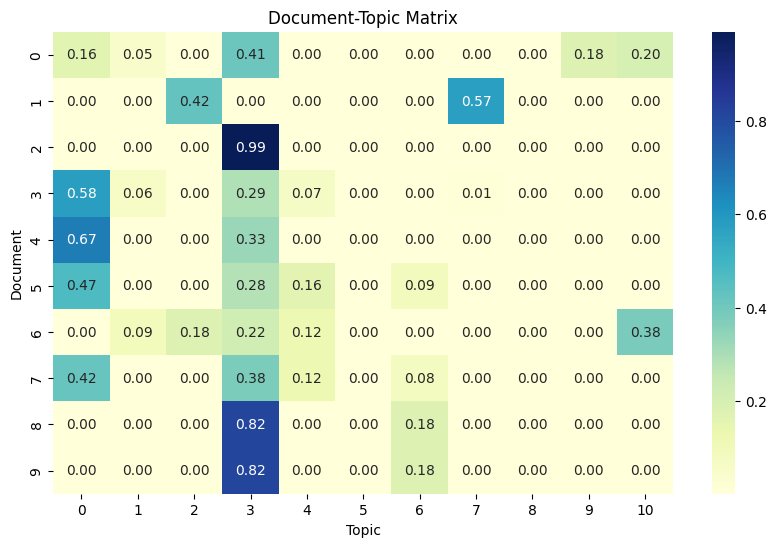

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sample Document-Topic Matrix (replace with your actual matrix)

topic_result_subset = topic_result[:10]


# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(topic_result_subset, cmap='YlGnBu', annot=True, fmt=".2f")
plt.xlabel('Topic')
plt.ylabel('Document')
plt.title('Document-Topic Matrix')
plt.show()

In [ ]:
old_values = [0,1, 2, 3,4,5,6,7,8,9]  # List of values to be replaced
new_values = ["Police Operations and [*Community Safety]",
              "Social Welfare and Government Services",
              "Community Health and Education Initiatives",
              "Local Government Development and Community Empowerment",
              "Elections and Political Participation",
              "[*Community Safety] and Festive Celebrations",
              "Local Governance and Community Development Initiatives",
              "Community Health and Welfare Programs",
              "Community Engagement and Local Leadership",
              "Community Development and Law Enforcement"]  # List of corresponding replacement values

df['topics_name'] = df['Topic'].replace(old_values, new_values)

In [ ]:
df


,target,title,text,lwr,clean_number,clean_punct,clean_double_ws,filtered,stemmed,filtered2,tokenized,Topic,topics_name
0,banggai,Mobil Sim Keliling Polres Banggai Meriahkan Pa...,KABAR LUWUK – Suasana Pasar Murah bersubsidi ...,kabar luwuk – suasana pasar murah bersubsidi ...,kabar luwuk – suasana pasar murah bersubsidi ...,kabar luwuk suasana pasar murah bersubsidi ...,kabar luwuk suasana pasar murah bersubsidi di ...,kabar suasana pasar murah bersubsidi banggai l...,kabar suasana pasar murah subsidi bangga lebih...,kabar suasana pasar murah subsidi bangga lebih...,"[kabar, suasana, pasar, murah, subsidi, bangga...",3,Local Government Development and Community Emp...
1,banggai,"Film Horor “Piara Mayat”, Kreativitas Anak Mu...","KABAR LUWUK – Film Horor“Piara Mayat”,Kreati...","kabar luwuk – film horor“piara mayat”,kreati...","kabar luwuk – film horor“piara mayat”,kreati...",kabar luwuk film horor piara mayat kreativ...,kabar luwuk film horor piara mayat kreativitas...,kabar film horor piara mayat kreativitasanak m...,kabar film horor piara mayat kreativitasanak m...,kabar film horor piara mayat kreativitasanak m...,"[kabar, film, horor, piara, mayat, kreativitas...",7,Community Health and Welfare Programs
2,banggai,Festival Malabot Tumbe 2023 Kembali Meriahkan ...,KABAR LUWUK –Festival Malabot Tumbe 2023Kemba...,kabar luwuk –festival malabot tumbe 2023kemba...,kabar luwuk –festival malabot tumbe kembali m...,kabar luwuk festival malabot tumbe kembali m...,kabar luwuk festival malabot tumbe kembali mer...,kabar festival malabot tumbe meriahkankabupate...,kabar festival malabot tumbe meriahkankabupate...,kabar festival malabot tumbe meriahkankabupate...,"[kabar, festival, malabot, tumbe, meriahkankab...",3,Local Government Development and Community Emp...
3,banggai,"Rakor Kampanye Damai Pemilu 2024, Polres Bangg...",“Kerja Cepat dan Terkoordinir dalam Penerbitan...,“kerja cepat dan terkoordinir dalam penerbitan...,“kerja cepat dan terkoordinir dalam penerbitan...,kerja cepat dan terkoordinir dalam penerbitan...,kerja cepat dan terkoordinir dalam penerbitan ...,kerja cepat terkoordinir penerbitan sttp kabar...,kerja cepat terkoordinir terbit sttp kabar rak...,kerja cepat terkoordinir terbit sttp kabar rak...,"[kerja, cepat, terkoordinir, terbit, sttp, kab...",0,Police Operations and [*Community Safety]
4,banggai,Bawaslu Banggai Perkuat Koordinasi dengan Panw...,KABAR LUWUK –Bawaslu BanggaiPerkuat Koordinas...,kabar luwuk –bawaslu banggaiperkuat koordinas...,kabar luwuk –bawaslu banggaiperkuat koordinas...,kabar luwuk bawaslu banggaiperkuat koordinas...,kabar luwuk bawaslu banggaiperkuat koordinasi ...,kabar bawaslu banggaiperkuat koordinasi dengan...,kabar bawaslu banggaiperkuat koordinasi dengan...,kabar bawaslu banggaiperkuat koordinasi dengan...,"[kabar, bawaslu, banggaiperkuat, koordinasi, d...",0,Police Operations and [*Community Safety]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,banggai,Jelang Voting Day Bawaslu Banggai Gelar Apel S...,Terasbanggai.com -Bawaslu Banggai akan meningk...,terasbanggai.com -bawaslu banggai akan meningk...,terasbanggai.com -bawaslu banggai akan meningk...,terasbanggai com bawaslu banggai akan meningk...,terasbanggai com bawaslu banggai akan meningka...,terasbanggai com bawaslu banggai meningkatkan ...,terasbanggai com bawaslu bangga tingkat awas j...,terasbanggai com bawaslu bangga tingkat awas j...,"[terasbanggai, com, bawaslu, bangga, tingkat, ...",0,Police Operations and [*Community Safety]
996,banggai,Bupati Banggai Ajak Warga Download Mobile JKN ...,"BANGGAI RAYA-Bupati Banggai, Ir. H. Amirudin M...","banggai raya-bupati banggai, ir. h. amirudin m...","banggai raya-bupati banggai, ir. h. amirudin m...",banggai raya bupati banggai ir h amirudin mm...,banggai raya bupati banggai ir h amirudin mm a...,banggai raya bupati banggai ir h amirudin mm a...,bangga raya bupati bangga ir h amirudin mm aif...,bangga raya bupati bangga ir h amirudin mm aif...,"[bangga, raya, bupati, bang

In [ ]:
text_test = df[["text","topics_name"]]
text_test

In [ ]:
text_test.to_excel('text_test.xlsx', index=False)